In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d skillsmuggler/amazon-ratings

 87% 25.0M/28.8M [00:00<00:00, 68.4MB/s]
100% 28.8M/28.8M [00:00<00:00, 67.8MB/s]


In [5]:
!unzip -q /content/amazon-ratings.zip -d /content/

In [6]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.6 MB/s eta 0:00:00


In [9]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163697 sha256=d9b6662c9100039ac71eed8b66553dd554c0a41cb4f07526021fb49f19295973
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datasketch import MinHash, MinHashLSH
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

In [ ]:
df = pd.read_csv('/content/ratings_Beauty.csv')

In [ ]:
df.shape

(2023070, 4)

In [ ]:
df.columns

Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')

In [ ]:
df.head(5)

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [ ]:
df['Date'] = df['Timestamp'].dt.date

In [ ]:
daily_counts = df.groupby('Date').size().reset_index(name='Count')

In [ ]:
daily_counts

,Date,Count
0,1970-01-01,2023070


In [ ]:
# Create a new column for the hour of the day
df['Hour'] = df['Timestamp'].dt.hour

# Group the data by hour and count the number of ratings for each hour
hourly_counts = df.groupby('Hour').size().reset_index(name='Count')

In [ ]:
hourly_counts

,Hour,Count
0,0,2023070


In [ ]:
# Find the minimum and maximum date
min_date = df['Timestamp'].min()
max_date = df['Timestamp'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 1970-01-01 00:00:00.908755200
Maximum Date: 1970-01-01 00:00:01.406073600


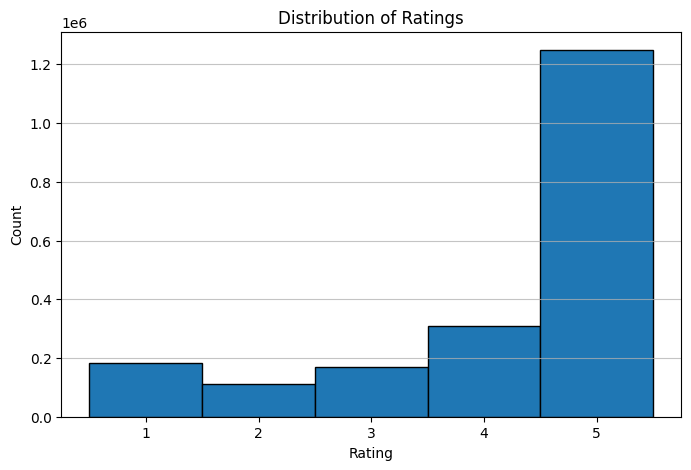

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'], bins=range(1, 7), align='left', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.75)
plt.show()

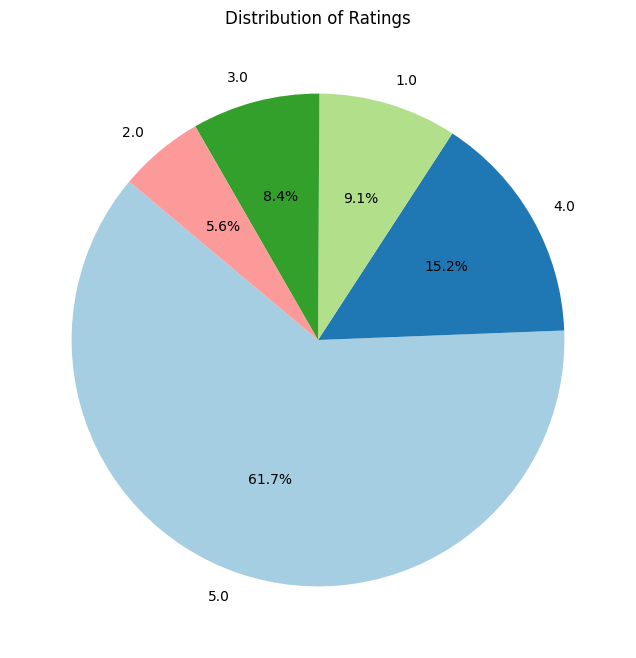

In [ ]:
rating_counts = df['Rating'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
# Calculate the average count of ratings for each user
user_avg_ratings = df.groupby('UserId')['Rating'].count().mean()

# Calculate the average count of ratings for each product
product_avg_ratings = df.groupby('ProductId')['Rating'].count().mean()

# Display the top 10 users with the highest count of ratings
top_users = df['UserId'].value_counts().head(10)

# Display the top 10 products with the highest count of ratings
top_products = df['ProductId'].value_counts().head(10)

print("Average count of ratings per user:", user_avg_ratings)
print("Average count of ratings per product:", product_avg_ratings)

print("\nTop 10 users with the highest count of ratings:")
print(top_users)

print("\nTop 10 products with the highest count of ratings:")
print(top_products)

Average count of ratings per user: 1.6715842980621696
Average count of ratings per product: 8.115848423822781

Top 10 users with the highest count of ratings:
UserId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
Name: count, dtype: int64

Top 10 products with the highest count of ratings:
ProductId
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
B000ZMBSPE    2041
B003BQ6QXK    1918
B004OHQR1Q    1885
B00121UVU0    1838
B000FS05VG    1589
Name: count, dtype: int64


In [ ]:
# Calculate the average rating and count of ratings for each user
user_stats = df.groupby('UserId')['Rating'].agg(['mean', 'count']).reset_index()
user_stats.columns = ['UserId', 'AvgRating', 'RatingCount']

# Calculate the average rating and count of ratings for each product
product_stats = df.groupby('ProductId')['Rating'].agg(['mean', 'count']).reset_index()
product_stats.columns = ['ProductId', 'AvgRating', 'RatingCount']

# Display the top 10 users with the highest count of ratings
top_users = user_stats.sort_values(by='RatingCount', ascending=False).head(10)

# Display the top 10 products with the highest count of ratings
top_products = product_stats.sort_values(by='RatingCount', ascending=False).head(10)

# Merge the original DataFrame with the user and product statistics
df = pd.merge(df, user_stats, on='UserId', how='left')
df = pd.merge(df, product_stats, on='ProductId', how='left')

# Display the new DataFrame with added columns
print(df.head())

# Display the top 10 users and products with the highest count of ratings
print("\nTop 10 users with the highest count of ratings:")
print(top_users)

print("\nTop 10 products with the highest count of ratings:")
print(top_products)

           UserId   ProductId  Rating                     Timestamp  \
0  A39HTATAQ9V7YF  0205616461     5.0 1970-01-01 00:00:01.369699200   
1  A3JM6GV9MNOF9X  0558925278     3.0 1970-01-01 00:00:01.355443200   
2  A1Z513UWSAAO0F  0558925278     5.0 1970-01-01 00:00:01.404691200   
3  A1WMRR494NWEWV  0733001998     4.0 1970-01-01 00:00:01.382572800   
4  A3IAAVS479H7M7  0737104473     1.0 1970-01-01 00:00:01.274227200   

         Date  Hour  AvgRating_x  RatingCount_x  AvgRating_y  RatingCount_y  
0  1970-01-01     0         4.25              4          5.0              1  
1  1970-01-01     0         3.50              2          4.0              2  
2  1970-01-01     0         5.00              1          4.0              2  
3  1970-01-01     0         4.00              1          4.0              1  
4  1970-01-01     0         1.00              9          1.0              1  

Top 10 users with the highest count of ratings:
                 UserId  AvgRating  RatingCount
821601  

In [33]:
df = pd.read_csv("/content/ratings_Beauty.csv")

In [34]:
df = df.drop('Timestamp', axis=1)

In [35]:
df.columns

Index(['UserId', 'ProductId', 'Rating'], dtype='object')

In [36]:
le_user = LabelEncoder()
le_product = LabelEncoder()

# Encode UserId and ProductId
df['UserId'] = le_user.fit_transform(df['UserId'])
df['ProductId'] = le_product.fit_transform(df['ProductId'])

In [37]:
scaler = MinMaxScaler()
df['Rating'] = scaler.fit_transform(df[['Rating']])

In [38]:
df.head()

,UserId,ProductId,Rating
0,725046,0,1.00
1,814606,1,0.50
2,313101,1,1.00
3,291075,2,0.75
4,802842,3,0.00


In [26]:
df = df.sample(frac=0.1, random_state=42)

In [ ]:
# sampled_df.shape

In [ ]:
df.shape

(202307, 4)

In [39]:
# Assuming df is your original DataFrame with 'UserId', 'ProductId', and 'Rating' columns
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train a collaborative filtering model (e.g., Singular Value Decomposition - SVD)
model = SVD()
model.fit(trainset)

In [40]:
# Make predictions on the test set
predictions = model.test(testset)

# Evaluate accuracy with RMSE
rmse = accuracy.rmse(predictions)
print("RMSE on test set:", rmse)

RMSE: 0.3906
RMSE on test set: 0.3905511196392996
